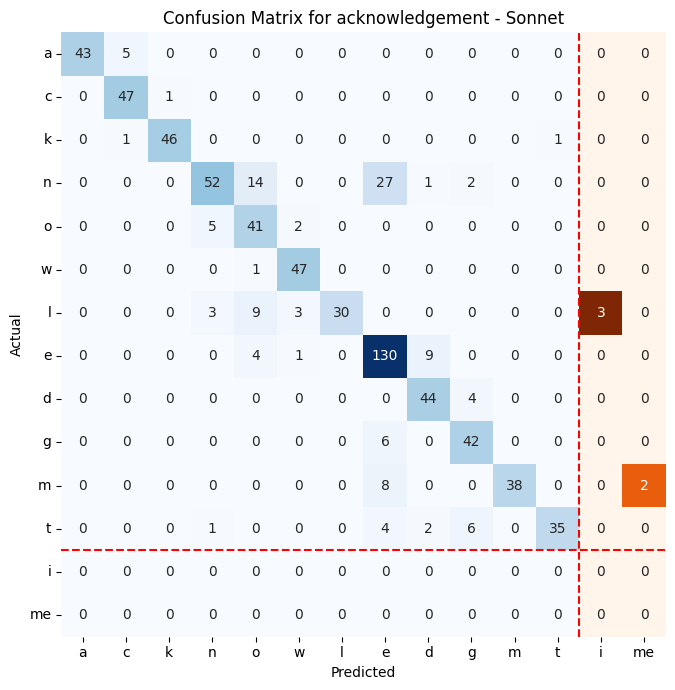

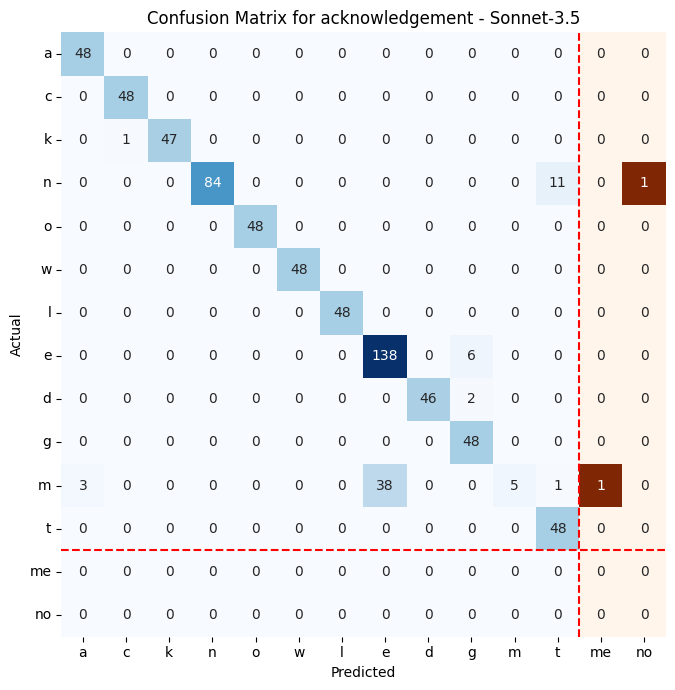

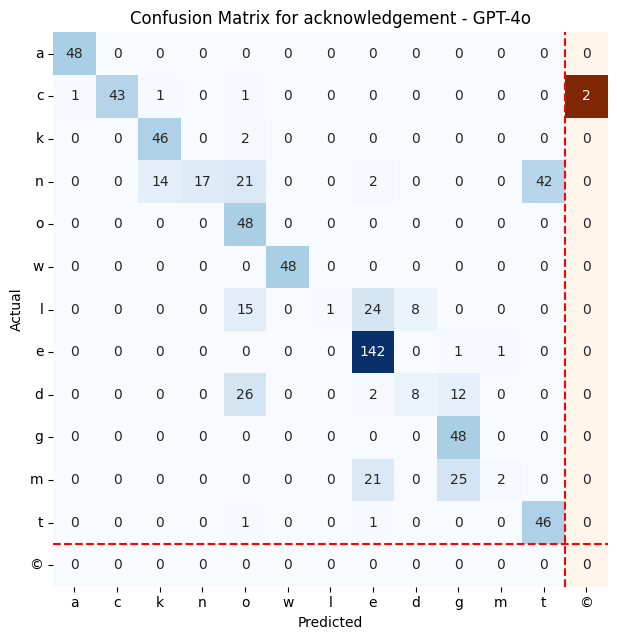

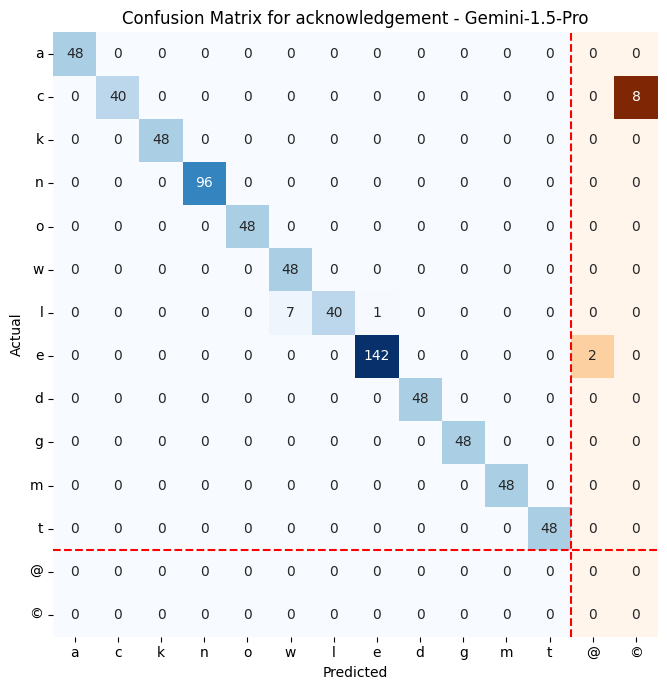

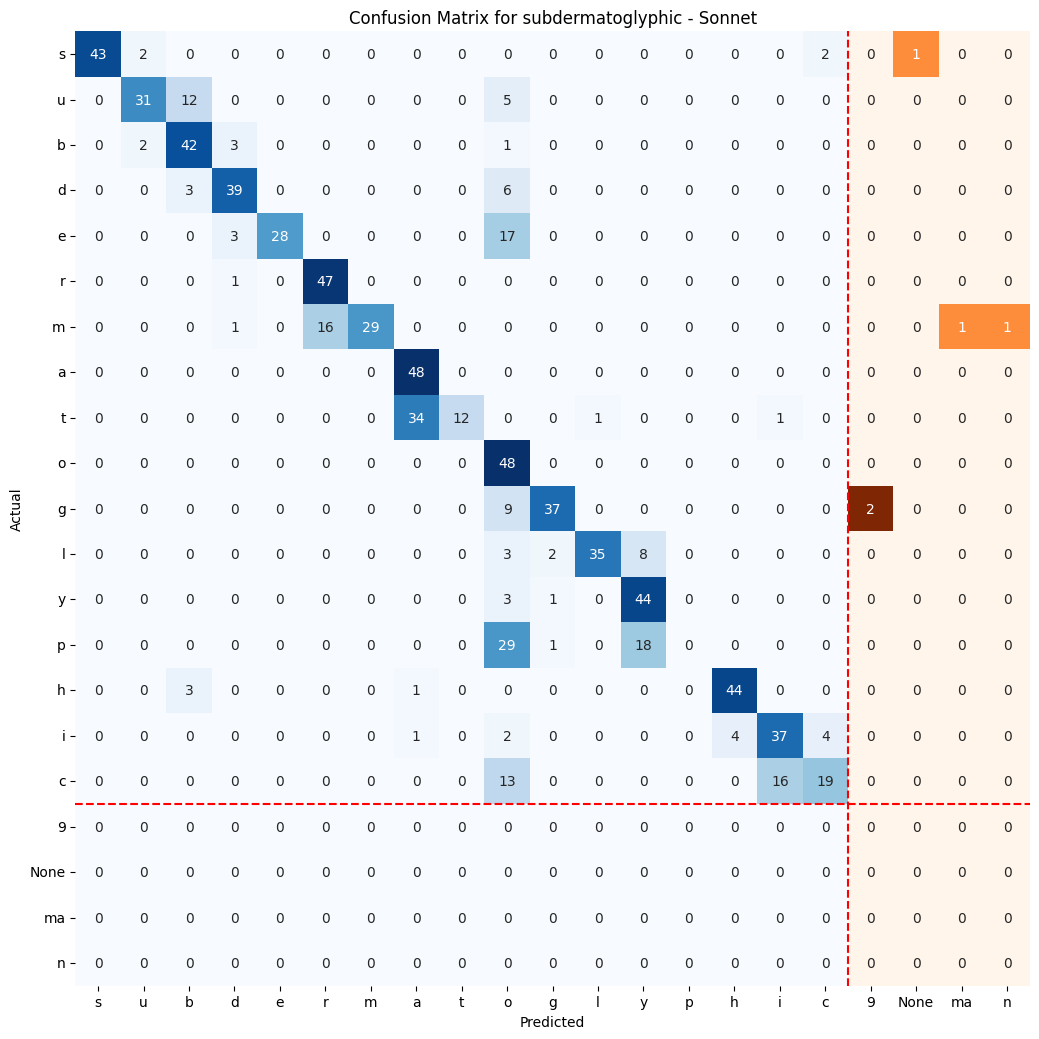

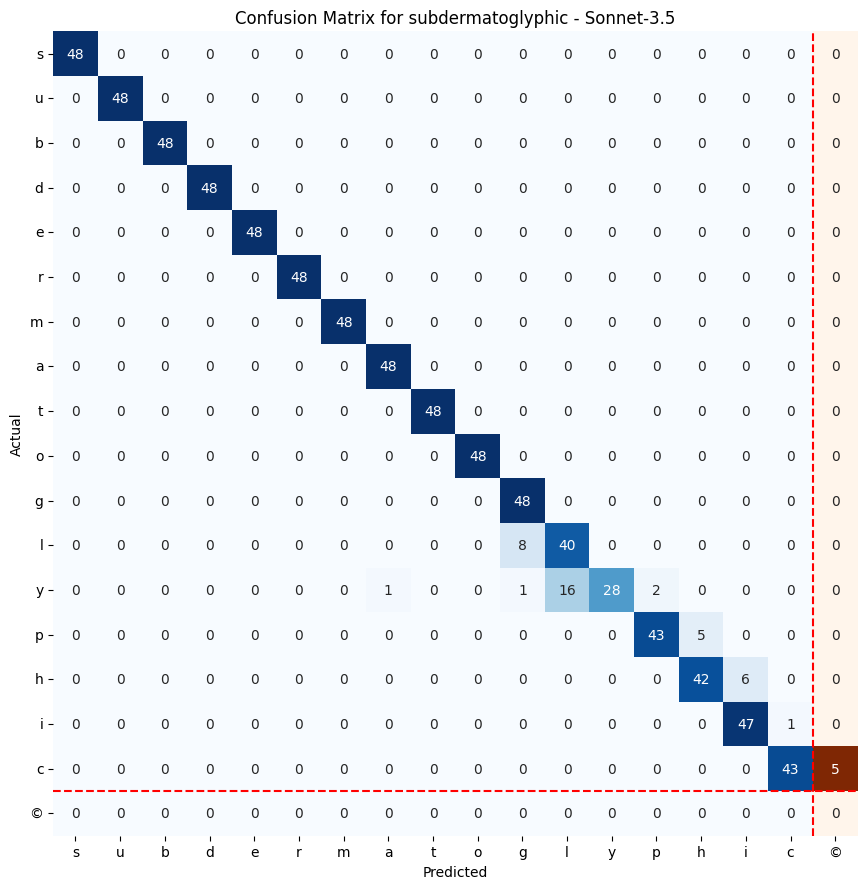

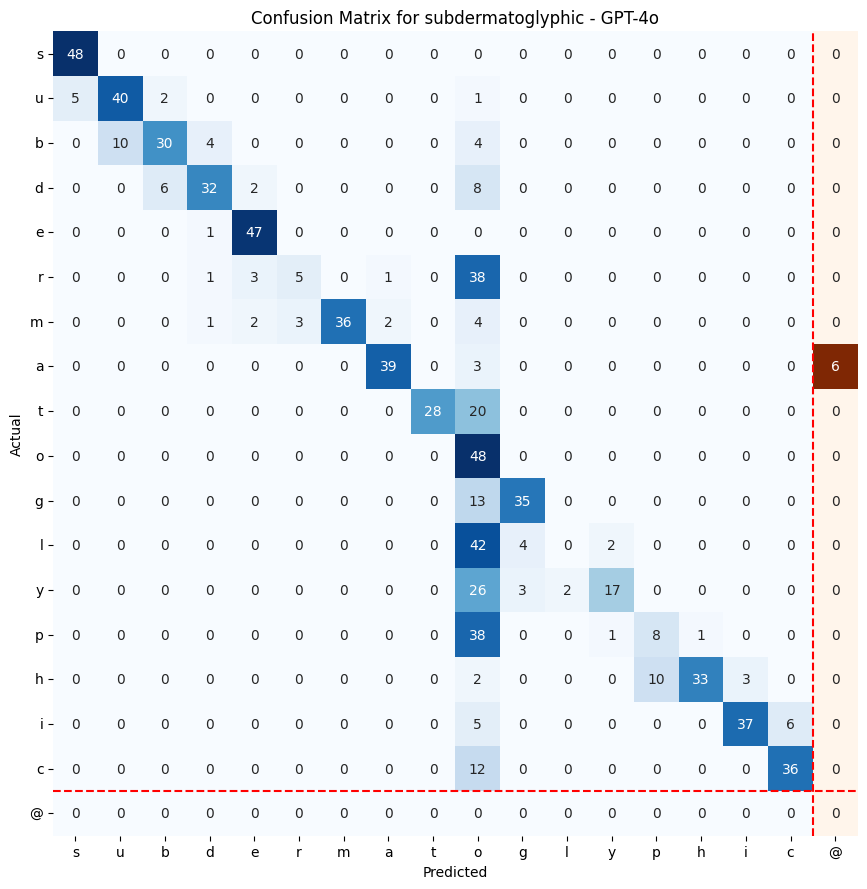

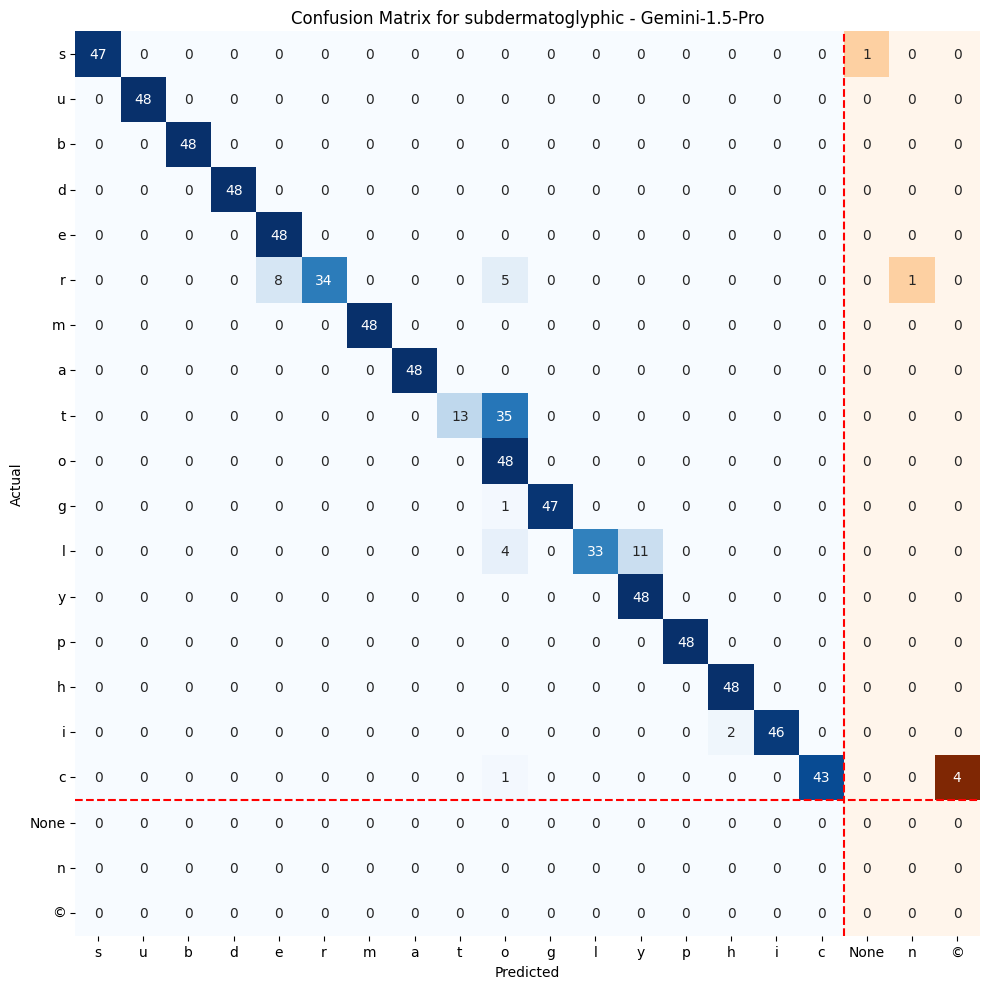

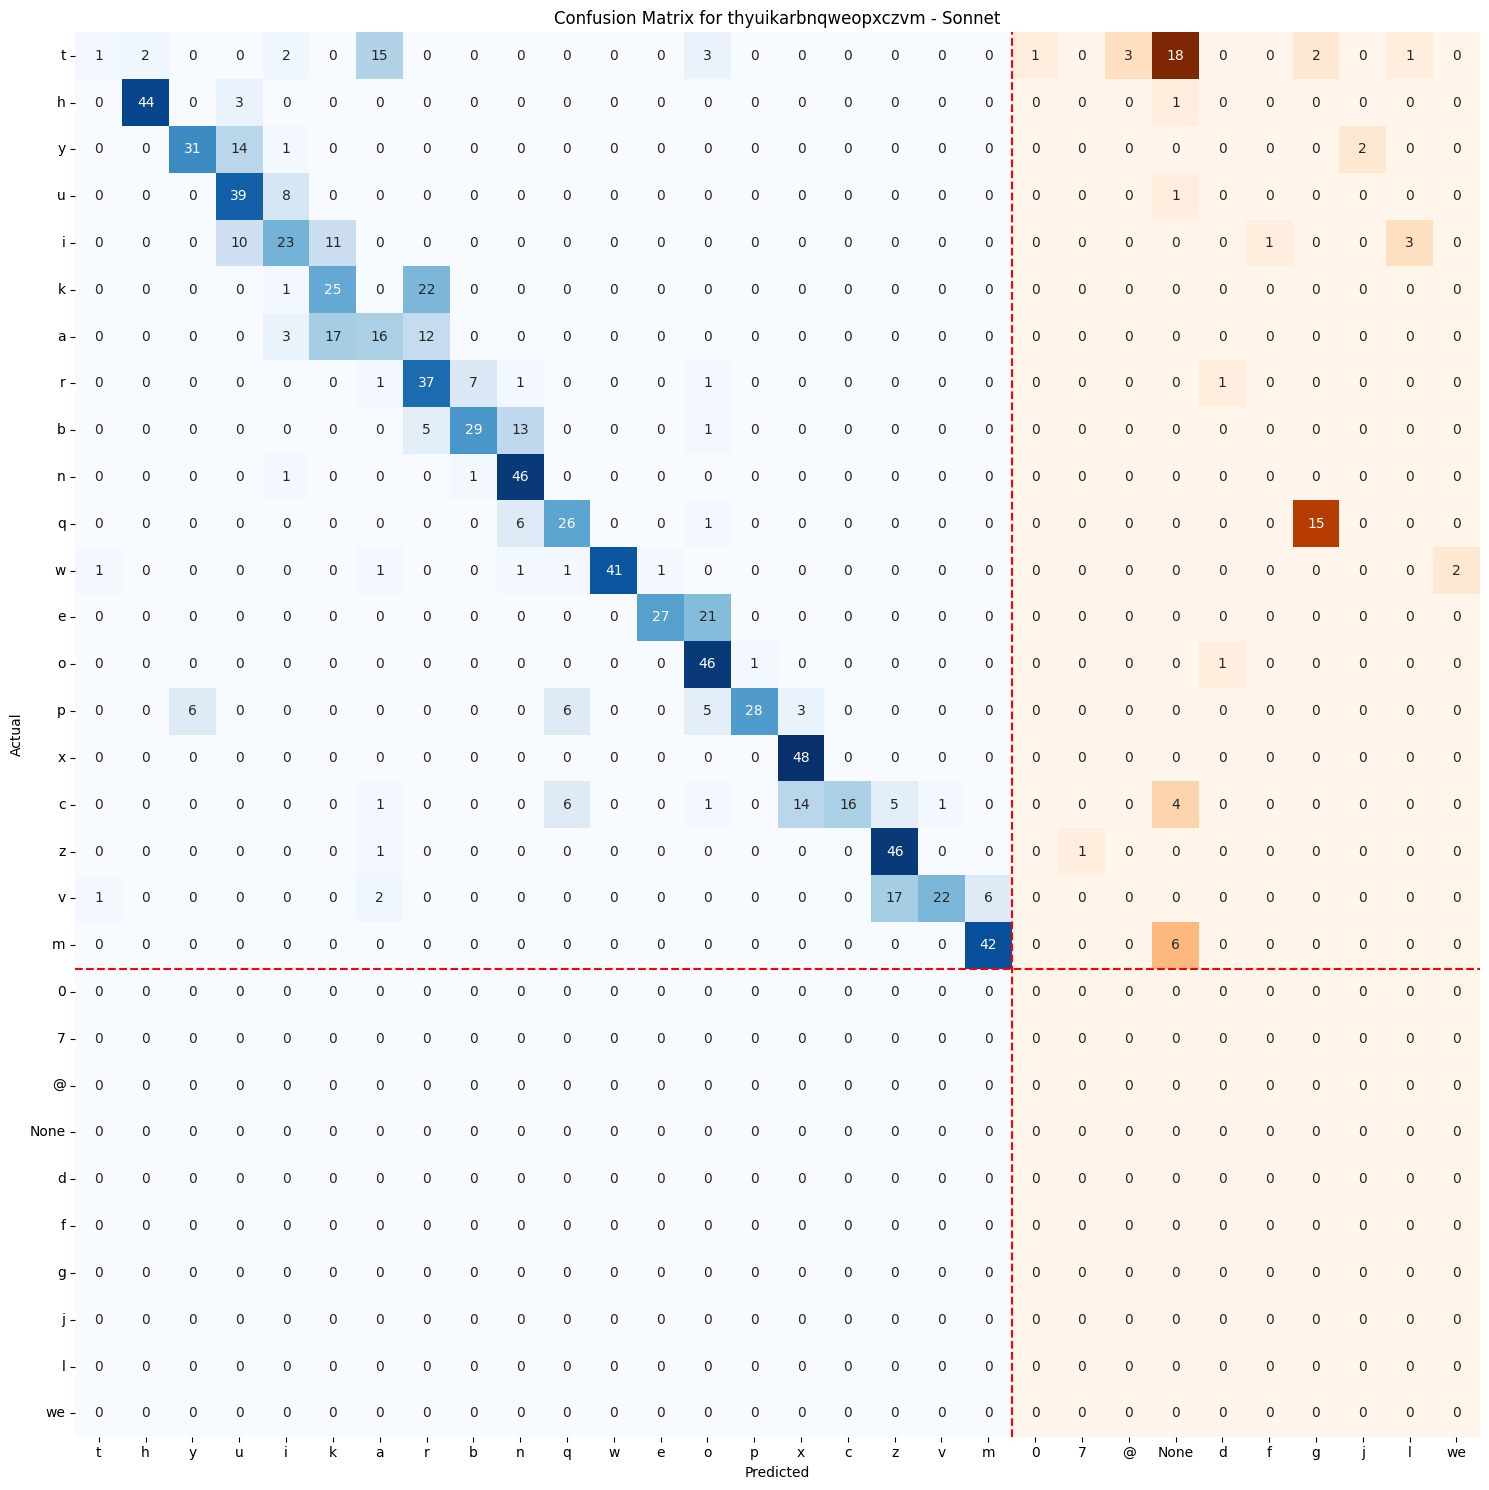

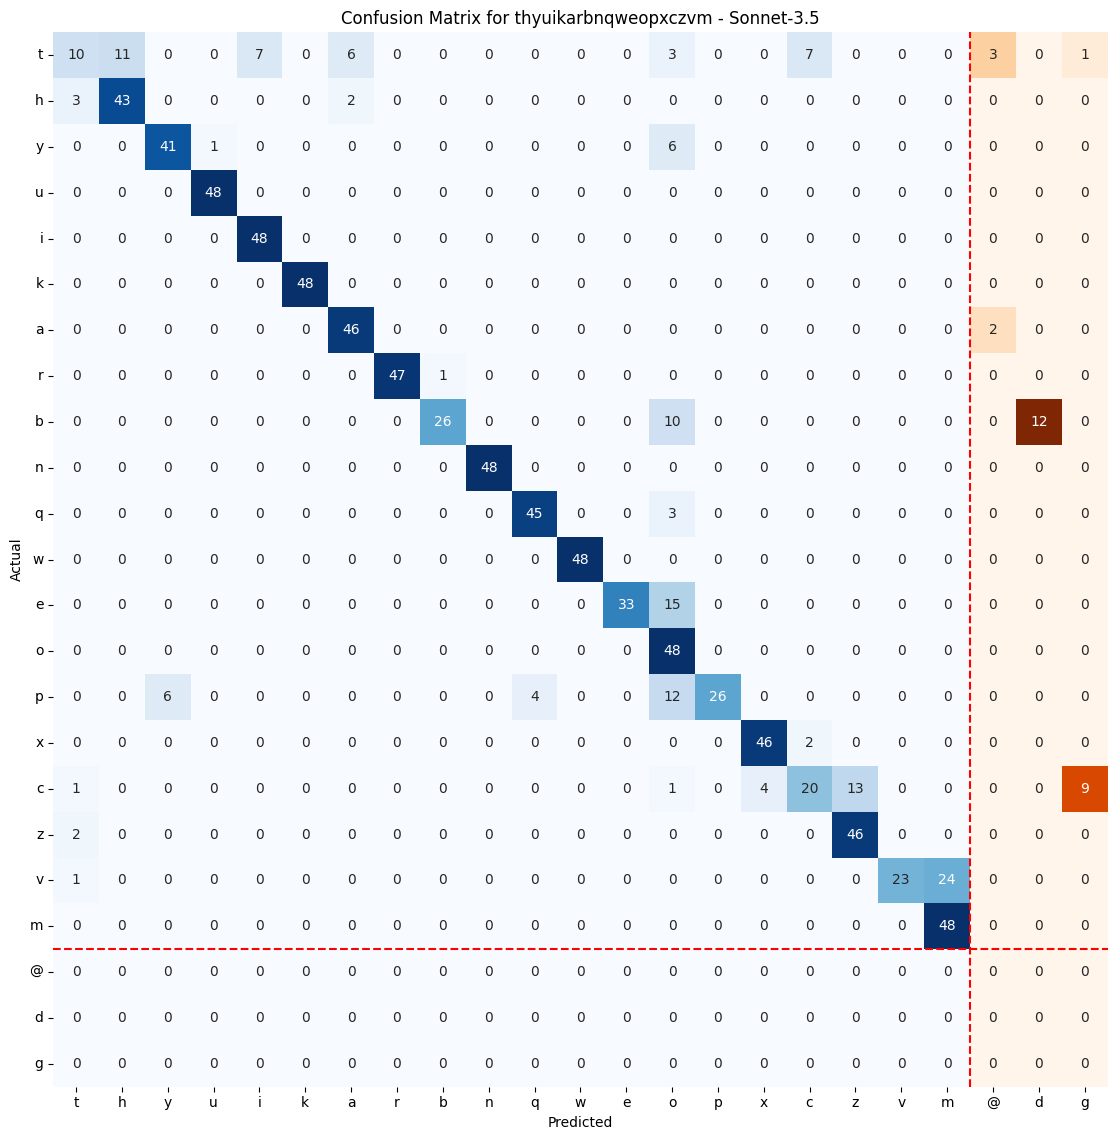

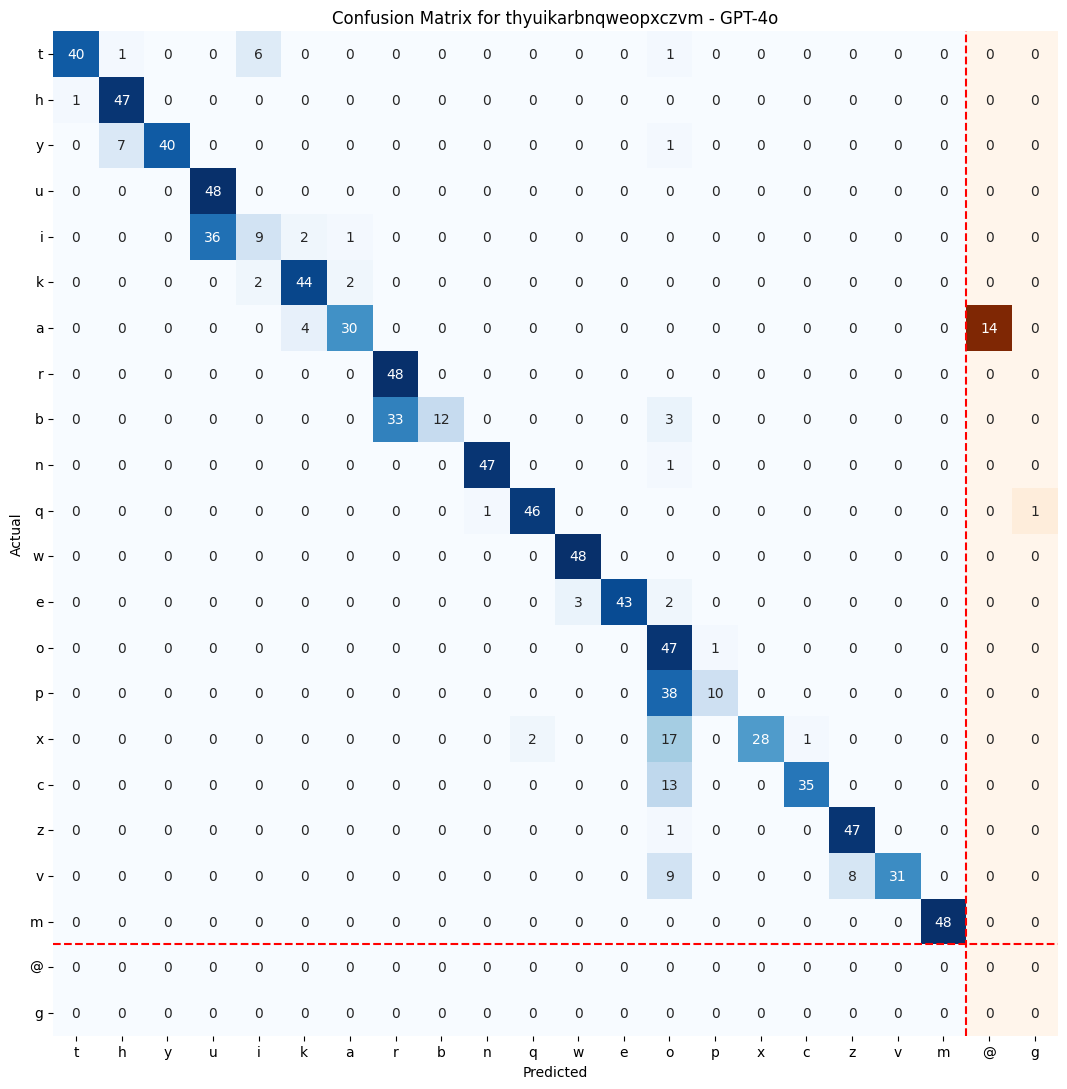

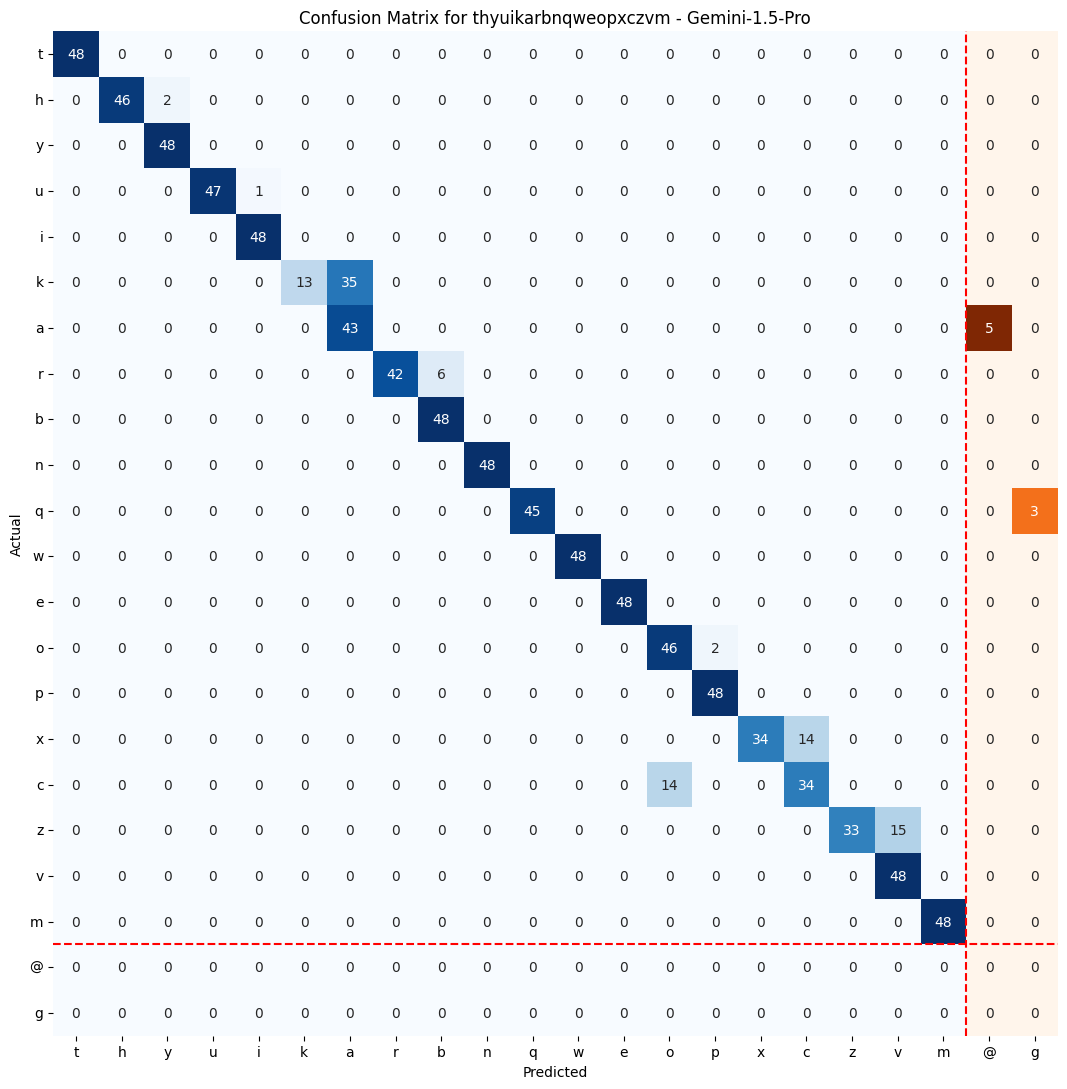

In [39]:
import pandas as pd
import json
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Load and preprocess data
pickle_files = [
    "./data/Sonnet-2.pkl",
    "./data/Sonnet-3.5-2.pkl",
    "./data/gpt-4o-2.pkl",
    "./data/gemini-1.5-pro-2.pkl",
]

dfs = [pd.read_pickle(file) for file in pickle_files]
df1 = pd.concat(dfs)
df1["prompt"] = "Which letter is being circled?"

pickle_files = [
    "./data/sonnet.pkl",
    "./data/Sonnet-3.5.pkl",
    "./data/gpt-4o.pkl",
    "./data/gemini-1.5-pro.pkl",
]

dfs = [pd.read_pickle(file) for file in pickle_files]
df2 = pd.concat(dfs)
df2["prompt"] = "Which character is being highlighted with a red oval?"

df = pd.concat([df1, df2])

# Convert both gt and predicted to lower case
df["gt"] = df["gt"].apply(lambda x: x.lower())
df["predicted"] = df["predicted"].apply(lambda x: x.lower())
df["is_prediction_correct"] = df["gt"] == df["predicted"]
df["word"] = df["word"].apply(lambda x: x.lower())

# Apply detection mapping
detection_mapping = {
    "none": "None",
    "no_red_oval": "None",
    'marker_not_foundthe letter "me" is being circled in the word "acknowledgement".': "me",
    'marker_not_foundthe letter being circled in the image is "me" from the word "acknowledgement".': "me",
    'marker_not_foundthe letter being circled in the image is "ma" within the word "subdermatoglyphic".': "ma",
    'marker_not_foundthe letter being circled in the given text is "we".': "we",
    'marker_not_foundthe letter being circled in the given text string is "we".': "we",
    'marker_not_foundthe letter being circled in the image is "no" within the word "acknowledgement". the red circle is drawn around the letters "no" in the middle of the word.': "no",
    'marker_not_foundthe letter being circled in the image is "me" within the word "acknowledgement".': "me",
}

df["predicted"] = df["predicted"].apply(lambda x: detection_mapping.get(x, x))


def plot_confusion_matrix(word, model):
    word_model_df = df[(df["word"] == word) & (df["Model"] == model)]

    # Get unique characters in the order they appear in the word
    word_chars = list(dict.fromkeys(word))

    # Add any extra characters that appear in predictions but not in the word
    all_chars = set(word_model_df["gt"].unique()) | set(
        word_model_df["predicted"].unique()
    )
    extra_chars = sorted(all_chars - set(word_chars))
    ordered_chars = word_chars + extra_chars

    # Create confusion matrix
    cm = confusion_matrix(
        word_model_df["gt"], word_model_df["predicted"], labels=ordered_chars
    )

    # Calculate the number of characters
    n_chars = len(ordered_chars)

    # Adjust figure size to make cells square
    cell_size = 0.5  # You can adjust this value to change the size of each cell
    fig_size = n_chars * cell_size
    plt.figure(figsize=(fig_size, fig_size))

    # Create a mask for word characters and extra characters
    word_mask = [
        [i < len(word_chars) for i in range(len(ordered_chars))]
        for _ in range(len(ordered_chars))
    ]
    extra_mask = [
        [i >= len(word_chars) for i in range(len(ordered_chars))]
        for _ in range(len(ordered_chars))
    ]

    # Plot heatmaps with different background colors
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        mask=np.array(word_mask) == False,
        xticklabels=ordered_chars,
        yticklabels=ordered_chars,
        cbar=False,
    )
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Oranges",
        mask=np.array(extra_mask) == False,
        xticklabels=ordered_chars,
        yticklabels=ordered_chars,
        cbar=False,
    )

    # Add lines to separate word characters from extra characters
    plt.axvline(x=len(word_chars), color="red", linestyle="--")
    plt.axhline(y=len(word_chars), color="red", linestyle="--")

    plt.title(f"Confusion Matrix for {word} - {model}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Rotate y-axis labels
    plt.yticks(rotation=0)

    # Ensure square cells
    plt.gca().set_aspect("equal", "box")

    plt.tight_layout()
    plt.show()


# Get unique words and models
words = df["word"].unique()
models = df["Model"].unique()

# Create confusion matrix for each word and model combination
for word in words:
    for model in models:
        plot_confusion_matrix(word, model)

In [40]:
# conver both gt and predicted to lower case
df["is_prediction_correct"] = df["gt"] == df["predicted"]

# Group by model and word, then calculate the accuracy
accuracy_per_model_and_word = df.groupby(["Model", "word"])[
    "is_prediction_correct"
].mean()

# Convert the accuracy to percentage and print the result
accuracy_per_model_and_word = accuracy_per_model_and_word * 100
# round 2 decimal places
accuracy_per_model_and_word = accuracy_per_model_and_word.round(2)

print(accuracy_per_model_and_word)

Model           word                
GPT-4o          acknowledgement         69.03
                subdermatoglyphic       63.60
                thyuikarbnqweopxczvm    77.92
Gemini-1.5-Pro  acknowledgement         97.50
                subdermatoglyphic       91.05
                thyuikarbnqweopxczvm    89.90
Sonnet          acknowledgement         82.64
                subdermatoglyphic       71.45
                thyuikarbnqweopxczvm    65.94
Sonnet-3.5      acknowledgement         91.11
                subdermatoglyphic       94.49
                thyuikarbnqweopxczvm    82.08
Name: is_prediction_correct, dtype: float64
